In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.getcwd()

'/home/adwai/BTP/genre'

In [3]:
import pickle
import torch
import utils
import data.utils as dutils
import matplotlib.pyplot as plt

import recourse.utils as rutils
from sklearn.neighbors import LocalOutlierFactor
from recourse.genre import GenRe


In [4]:
import models.binnedpm as bpm

In [5]:
exp_config = utils.load_config('results/exp1_config.yaml')

----------------------------- Executing for Dataset squares -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/squares/ann_rf_tt_mm_8_4


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

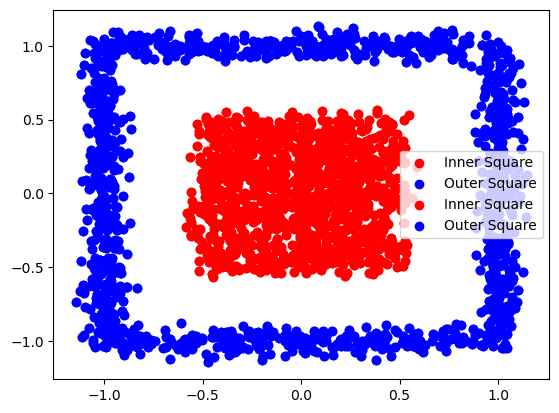

In [10]:
import torch.random


for DATASET_STR in ['squares']:
    for train_lambda in [0.9]: #[20.0]:
        print(f"----------------------------- Executing for Dataset {DATASET_STR} -----------------------------")
        YSTAR = 1.0
        DEVICE = 'cuda:0'
        TRAIN_P = 1
        SEED = 42

        utils.set_seed(SEED)

        # load dataset
        train_y,train_X,test_y,test_X, cat_mask, immutable_mask = dutils.load_dataset(DATASET_STR, ret_tensor=True, min_max=True, ret_masks=True)
        INPUT_SHAPE = train_X.shape[1]

        LABEL_PATH =  utils.get_rf_folder(DATASET_STR,True,True)
        train_y,train_X,test_y,test_X = dutils.load_dataset(DATASET_STR, cust_labels_path=LABEL_PATH, ret_tensor=True, min_max=True)
        INPUT_SHAPE = train_X.shape[1]
        ann_clf, ann_folder = utils.load_ann(INPUT_SHAPE=INPUT_SHAPE,DATASET_STR=DATASET_STR, 
                                                LABEL_SRC='rf',**exp_config['common'],**exp_config['ann'][DATASET_STR])

        # heloc, compas-all, adult-all
        pair_model = bpm.PairedTransformerBinned(n_bins=50,
                                            num_inputs=INPUT_SHAPE,
                                            num_labels=1,
                                            num_encoder_layers=16,
                                            num_decoder_layers=16,
                                            emb_size=32,
                                            nhead=8,
                                            dim_feedforward = 32,
                                            dropout= 0.1).to(DEVICE)

        PM_STATE_PATH  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'

        state = torch.load(PM_STATE_PATH, map_location='cpu')
        pair_model.load_state_dict(state["state_dict"])
        pair_model = pair_model.to(DEVICE)
        pair_model.eval()

        loss_log = {k:state[k] for k in ('train','val','test')}
        
        fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(10, 20))
        # fig.set_size_inches(10, 20)
        utils.plot_curves(ax[0],loss_log)

        best_epoch = state['epoch']
        ax[0].set_title(f'{DATASET_STR} --- {train_lambda=} --- {best_epoch}')
        

        ann_clf = ann_clf.to(DEVICE)


        # # get negative instances
        xf_r = rutils.get_neg_inst(ann_clf,test_X,YSTAR,sample=1000)
        xf_r = xf_r.to(DEVICE)
        # wf random weights between 0 and 1 , with same shape as xf_r
        # wf weights 1,0 for first feature and 0 for rest of the features


        wf = torch.rand([xf_r.shape[0],xf_r.shape[1]], device=DEVICE)
        wf[:,0]=0.0
        wf[:,1]=1.0
        
        # wf = torch.rand([xf_r.shape[0],xf_r[0].shape], device=DEVICE)
        # print(wf)
        # broadcast to match the shape of xf_r
        # wf = wf.unsqueeze(1).repeat(1, xf_r.shape[1])
        print(xf_r.shape)
        print(wf.shape)

        # experiment_name = f'paper_experiments'
        # common_dir = f"./results/{experiment_name}/{DATASET_STR}"
        # with open(f"{common_dir}/xf_r", "rb") as fp:
        #     xf_r = pickle.load(fp).cpu()
        # xf_r = xf_r.to(DEVICE)
        # xf_r = torch.tensor([[0.25,0.75],[0.25,0.25],[0.75,0.25],[0.75,0.75]], device=DEVICE)
        # xf_r = torch.tensor([[0.0,0.5],[0.5,1.0],[0.5,0],[0,1]], device=DEVICE)
        # xf_r = torch.tensor([[0.0,0.4],[0.25,0.8],[0.3,0.9],[0.4,1.0]], device=DEVICE)

        print(len(xf_r))
        
        rec_module = GenRe(pair_model=pair_model, temp=10, sigma=0.001, best_k=10, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
        sample_xcf = rec_module(xf_r,wf)
        print(sample_xcf)
        utils.viz_clf(ax[1],ann_clf,train_X,train_y,hard=True)
        utils.scatter2d(ax[1],train_X,train_y,data_name='training data', s=20, show_axis_name=False)
        utils.plot_pairs(ax[1],xf_r,sample_xcf,None,arrows=True, names=('negative instances',"recourse instances"), s=40, edgecolor = "#333",show_axis_name=False)





        
        plt.show()
        # yf_r = torch.ones(xf_r.shape[0]).to(DEVICE)*YSTAR

        # utils.set_seed(42)
        # sample_xcf = pair_model._sample(xf_r, yf_r, y=yf_r*0 + YSTAR, temp=10.0, sigma=0.000)
        # sample_xcf[:,cat_mask] = torch.round(sample_xcf[:,cat_mask])

        # output_dir = f"{common_dir}/genre_{train_lambda}_gamma0.7"
        # os.makedirs(output_dir, exist_ok=True)
        # with open(f"{output_dir}/xcf", "wb") as fp:
        #     pickle.dump(sample_xcf.cpu(), fp)
        
        # print(output_dir)
        # print(f'------------------- sample {DATASET_STR} -------------------')

        # set up all the classifiers
        # pre-trained rf classifier
        # STATE_PATH = os.path.join(LABEL_PATH, "state.pkl")
        # with open(STATE_PATH, 'rb') as f:
        #     rf_clf = pickle.load(f)
        # all_X = torch.concatenate((train_X,test_X))
        # all_pred = rf_clf.predict(all_X)
        # all_pred_prob = rf_clf.predict_proba(all_X) 

        # # outlier factor classifier
        # lof_clf = LocalOutlierFactor(n_neighbors=5, novelty=True)
        # lof_clf.fit(all_X[all_pred==YSTAR])
        
        # print(f'{DATASET_STR} --- {train_lambda=}')
        # print('lof',utils.msstr((lof_clf.predict(sample_xcf.cpu())+1)/2,with_std=True))
        # print('hval gold classifier',utils.msstr(rf_clf.predict_proba(sample_xcf.cpu())[:,int(YSTAR)]>0.5,with_std=True))
        # print('sval gold classifier',utils.msstr(rf_clf.predict_proba(sample_xcf.cpu())[:,int(YSTAR)],with_std=True))
        # print('hval ann',utils.msstr((ann_clf(sample_xcf)>0.5)*1.0,with_std=True))
        # print('cost',utils.msstr(rutils.cost_fn(sample_xcf,xf_r), with_std=True))
        # raise